In this notebook I will try to fit a single star PSF model to a calibrator star from kernel phase data set. 
To do that I will need to fit only x, y center positions and median flux as in de Furio paper. In addition to that we I can add phase retrieval and improve model-data fitting

To fit a binary model, which I will do in a separate notebook, I will need to have more parameters, but first basic parameters are  x and y center of the primary, flux normalization of the primary, separation between the centers of the primary and secondary, the position angle of the center of the secondary relative to the primary, and the flux ratio between the secondary and primary. On top of that I can add phase retrieval parameters to the model. 

Functions I need:
1. grid search in x,y parameter space
2. plots to save
3. data for plots to be saved
4. de furio like 3x3 plot with fitting single and binary models to the binary data
5. sbatch run file
6. repeate code for every filter

In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

# Set CPU count for numpyro multi-chain multi-thread
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

import dLux as dl
from matplotlib import colors, pyplot as plt
import jax.numpy as np
from jax import jit, vmap
import jax.random as jr

import webbpsf
from astropy.io import fits
import astropy.units as u
from tqdm.notebook import tqdm

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


In [2]:
from dLux import LayeredOptics

Step 1: Make fake data with the same parameters as real data.

In [31]:
# Define the parameters
wf_npixels = 1024
diameter = 6 # metres
psf_npixels = 56
psf_pixel_scale = 0.063 * np.pi / (180*3600)

layers = [
    #(dl.ApertureFactory(wf_npixels), 'aperture'),
    dl.MFT(psf_npixels, psf_pixel_scale),
]

# Construct the optics class
optics = dl.LayeredOptics(wf_npixels, diameter, layers)

wavelengths = np.array([2.82792251e-06])
psf = optics.propagate(wavelengths)

data = psf

(56, 56)


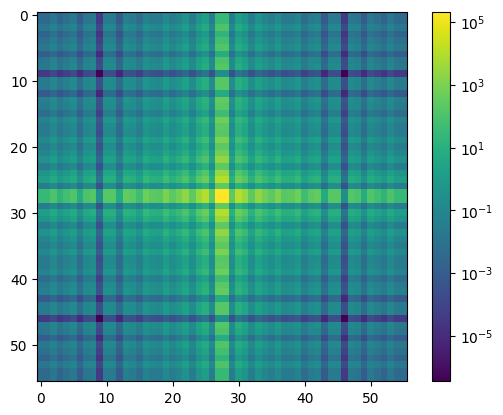

In [32]:
plt.imshow(data, norm="log")
plt.colorbar()
print(data.shape)

Now as we got fake data, lets tru to grid search the star position so we can pass it to the HMC as initial guess. 

In [24]:
parameters = ['source.position']

# Define the likelihood function
model = telescope

# Define the meshgrid
xsize = 256
ysize = 256
allsize = xsize*ysize

xmin = toRad(-1)
xmax = toRad(1)
ymin = toRad(-1)
ymax = toRad(1)


xx, yy = np.meshgrid(np.linspace(xmin, xmax, xsize), np.linspace(ymin, ymax, ysize))

xr = xx.reshape((allsize))
yr = yy.reshape((allsize))


xstep = toArcsec(xr[1] - xr[0])
ystep = toArcsec(yr[1] - yr[0])

In [25]:
from jax import lax

def likelihood(x, y, expected_data):
    model_data = model.set(parameters, [[x, y]]).model()
    residuals = expected_data - model_data
    # calculate the chi-squared value
    chi_squared = np.sum(residuals**2)
    # calculate the likelihood
    likelihood =  -0.5 * chi_squared  #log likelihood
    print(f"x={x}, y={y}, chi_squared={chi_squared}")
    return likelihood

@jit
def likelihood_fast(x,y,expected_data):
    likelihood_c = lambda args : likelihood(args[0], args[1], expected_data)
    args = np.stack((x, y), axis=-1)
    return lax.map(likelihood_c, args)


In [26]:
%%time
out = likelihood_fast(xr, yr, data)

x=Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>, y=Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>, chi_squared=Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>
CPU times: user 2min 44s, sys: 9.18 s, total: 2min 53s
Wall time: 56.3 s


In [27]:
likelihoods = np.array(out).reshape((xsize, ysize))
#print(likelihoods)

ind_argmax = out.argmax()
coords=(xr[ind_argmax], yr[ind_argmax])

#ind_max = np.unravel_index(likelihoods.argmax(), likelihoods.shape)
#coords=(xx[ind_max[0], ind_max[1]], yy[ind_max[0], ind_max[1]])

x_recovered = toArcsec(coords[0])
y_recovered = toArcsec(coords[1])

print(f'   rad: {coords[0]}, {coords[1]}')
print(f'arcsec: {x_recovered}, {y_recovered}')
#print(f'rho,th: {rho_rec}, {theta_rec}')

   rad: 7.414797475792902e-07, 1.463947193938599e-06
arcsec: 0.15294117647058822, 0.3019607843137255


In [28]:
flux = np.sum(data)
log_flux = np.log(flux)
print(log_flux)

9.697754062731514


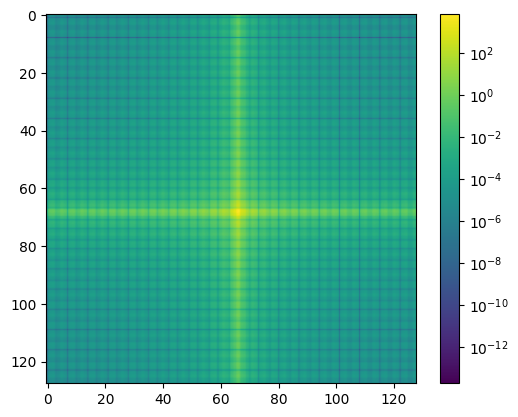

In [29]:
offset_found = np.array([coords[0], coords[1]])
source_found = dl.PointSource(wavelengths=wavels, spectrum=spec, position=offset_found)
telescope_found = dl.Instrument(optics, (source_found,'source'))

psf_found = telescope_found.model()
plt.imshow(psf_found, norm="log")
plt.colorbar()

In [30]:
toArcsec(offset_found)

Array([0.15294118, 0.30196078], dtype=float64)

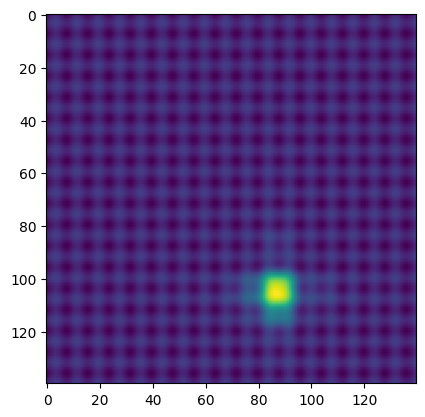

In [31]:
plt.imshow(likelihoods[60:200,60:200])

In [23]:
std = np.std(bg_noise)

In [24]:
std

Array(0.00948187, dtype=float64)

Step 3: Set up HMC parameters and distributions.

In [25]:
import numpyro as npy
import numpyro.distributions as dist

#parameters = ['position', 'flux']
parameters = ['position']

std = 0.01 * np.ones_like(data.flatten())

coord_range = xstep*2
log_flux_range = 2

def psf_model(data, data_err, model):
    """
    Define the numpyro function
    """
    #x_sample = npy.sample("x_arcsec", dist.Uniform(x_recovered - coord_range, x_recovered + coord_range))
    #y_sample = npy.sample("y_arcsec", dist.Uniform(y_recovered - coord_range, y_recovered + coord_range))
    
    x_sample = npy.sample("x_arcsec", dist.Uniform(0.1, 0.35))
    y_sample = npy.sample("y_arcsec", dist.Uniform(0.1, 0.35))
    
    #flux_sample  = npy.sample("log_flux", dist.Uniform(log_flux - log_flux_range, log_flux + log_flux_range))
    
    #det_flux = np.exp(flux_sample)
    det_x = toRad(x_sample)
    det_y = toRad(y_sample)
    
    values = [
        [det_x, det_y],
        #det_flux
    ]
    
    with npy.plate("data", len(data.flatten())):
        dist_model = dist.Normal(model.set(parameters, values).model().flatten(), data_err)
        npy.sample("psf", dist_model, obs=data.flatten())

In [26]:
#sampler. run(jax. random. PRNGKey(0), yerr, y-y)
#inf_data = az. from_numpyro (sampler)
#inf_data.to_netcdf(os-path.join(self.outputs,(self.hdnum+*_*+self-method+*h5°)))

In [27]:
from jax import device_count
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),    
    num_warmup=1000,
    num_samples=1000,
    num_chains=device_count(),
    progress_bar=True,
)
%time sampler.run(jr.PRNGKey(0), data, std, telescope)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 1min 36s, sys: 4.68 s, total: 1min 41s
Wall time: 29.8 s


Step 4: Make plots.

In [28]:
sampler.print_summary()
values_out = sampler.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  x_arcsec      0.27      0.03      0.28      0.22      0.31      2.00   1938.17
  y_arcsec      0.19      0.05      0.20      0.13      0.25      2.00   1535.98

Number of divergences: 16


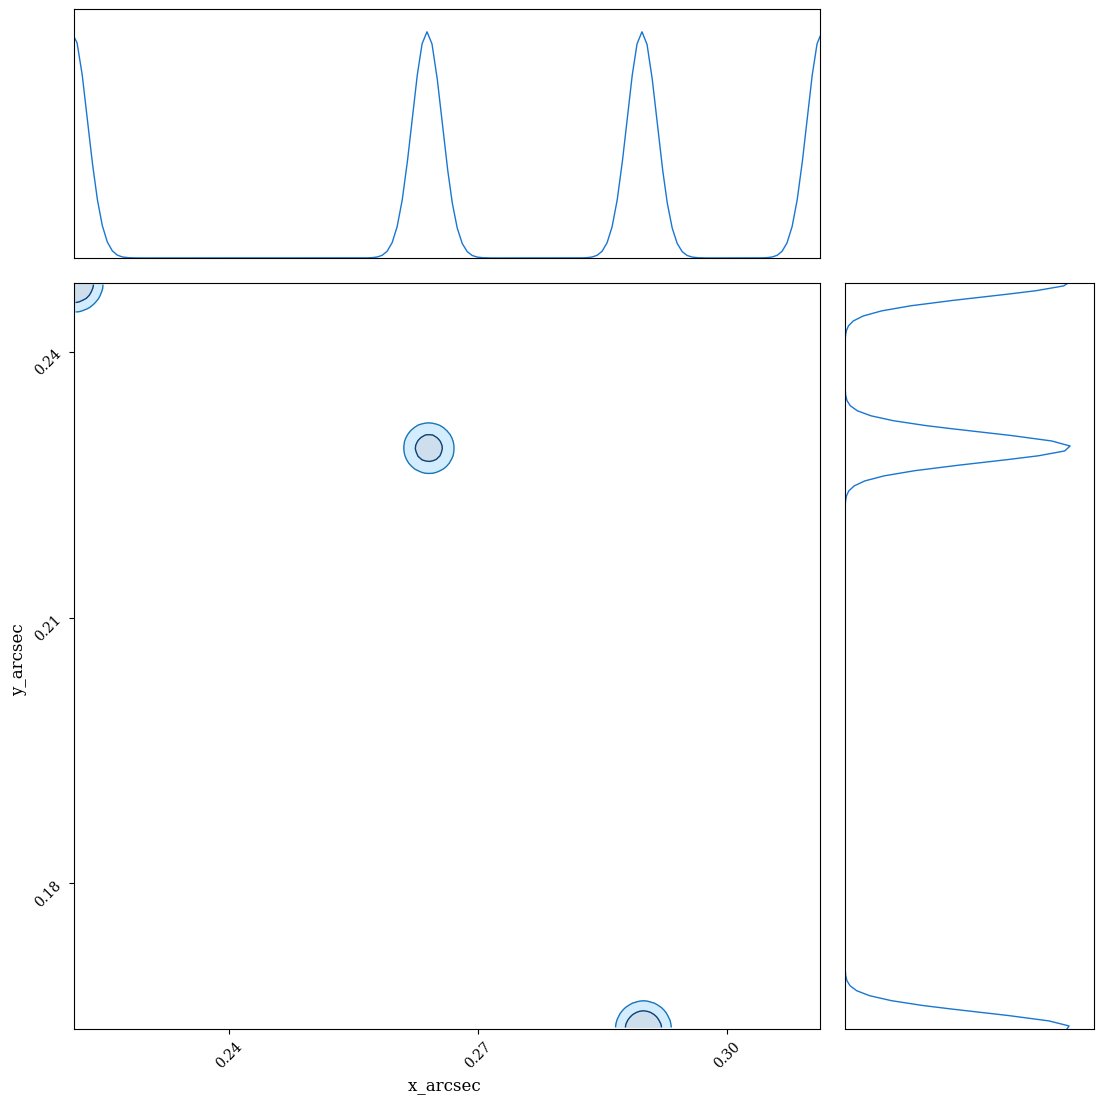

In [29]:
import chainconsumer as cc

chain = cc.ChainConsumer()
chain.add_chain(values_out)
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = chain.plotter.plot()
fig.set_size_inches((12, 12));